In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from tqdm import tqdm
from karies.models import MaskRCNN, U_Net_Model
from pixpro_utils import MaskRCNNModelWrapper, UNetModelWrapper
from torch.cuda.amp import GradScaler
from pixpro_utils import PretrainingDataset, print_model_size
from karies.config import DatasetPartition, ModelTypes
from pixel_level_contrastive_learning import PixelCL
import sys

sys.path.append("/cluster/group/karies_2022/Simone/karies/karies-models/")
from configs.MaskRCNN.default_model_setting_config import model_config as config_maskrcnn
from configs.UNet.baseline_unet_config import model_config as config_unet

## MaskRCNN

Explanation on how to run this with the custom PixelCL at the end of the notebook

In [ ]:
config_maskrcnn["name"] = "PIXPRO-TEST-DELETE"
config_maskrcnn["batch_size"] = 10
config_maskrcnn["device"] = "cuda"
config_maskrcnn["augmentations"] = []
config_maskrcnn["fix_random_seed"] = 42
config_maskrcnn["image_shape"] = None

crop_size = 56
# mixed_precision = True

# maskrcnn = MaskRCNN(config_maskrcnn, load=False)
# print_model_size(maskrcnn.model)

# wrap = MaskRCNNModelWrapper(
#     maskrcnn.model.transform,
#     maskrcnn.model.backbone,
# )

dl = PretrainingDataset(
    config_maskrcnn,
    DatasetPartition.train,
    crop_size=crop_size,
    dataset="4k",
    unlabelled="bw+"
).get_data_loaders()

In [ ]:
learner = PixelCL(
    wrap,
    image_size = (crop_size, crop_size),
    hidden_layer_pixel = 'extra_layer',  # leads to output of 8x8 feature map for pixel-level learning
    hidden_layer_instance = 'avgpool',     # leads to output for instance-level learning
    projection_size = 256,          # size of projection output, 256 was used in the paper
    projection_hidden_size = 2048,  # size of projection hidden dimension, paper used 2048
    moving_average_decay = 0.99,    # exponential moving average decay of target encoder
    ppm_num_layers = 1,             # number of layers for transform function in the pixel propagation module, 1 was optimal
    ppm_gamma = 2,                  # sharpness of the similarity in the pixel propagation module, already at optimal value of 2
    distance_thres = 0.7,           # ideal value is 0.7, as indicated in the paper, which makes the assumption of each feature map's pixel diagonal distance to be 1 (still unclear)
    similarity_temperature = 0.3,   # temperature for the cosine similarity for the pixel contrastive loss
    alpha = 1.,                      # weight of the pixel propagation loss (pixpro) vs pixel CL loss
    use_pixpro = True,               # do pixel pro instead of pixel contrast loss, defaults to pixpro, since it is the best one
    cutout_ratio_range = (0.6, 0.8)  # a random ratio is selected from this range for the random cutout
).cuda()

In [ ]:
scaler = GradScaler(enabled=mixed_precision)
opt = torch.optim.Adam(learner.parameters(), lr=1e-4)

torch.cuda.empty_cache()

def sample_batch_images():
    return torch.randn(8, 3, crop_size, crop_size).cuda()

for _ in tqdm(range(5)):
    images = sample_batch_images()
    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=mixed_precision):
        loss = learner(images) # if positive pixel pairs is equal to zero, the loss is equal to the instance level loss

    opt.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    learner.update_moving_average() # update moving average of target encoder


## UNet

In [ ]:
config_unet["name"] = "PIXPRO-TEST-DELETE"
config_unet["batch_size"] = 100
config_unet["device"] = "cpu"
config_unet["dataset"] = "dataset_4k"
config_unet["augmentations"] = []
config_unet["fix_random_seed"] = 42
config_unet["image_shape"] = [768, 1024]
config_unet["unet_type"] = ModelTypes.U_Net
config_unet["model_args"]["encoder_name"] = "resnet50"

crop_size = 112
mixed_precision = False


unet = U_Net_Model(config_unet, load=False)
print_model_size(unet.model)

unet_wrap = UNetModelWrapper(
    unet.model.encoder
)

dl = PretrainingDataset(
    config_unet,
    DatasetPartition.train,
    crop_size=crop_size,
    only_seg_masks=True
).get_data_loaders()


In [ ]:
def p(model, input, output):
    print(output.shape)

handles = []
handles.append(unet_wrap.register_forward_hook(p))
handles.append(unet_wrap.encoder.layer4.register_forward_hook(p))

x = next(iter(dl))
print(x.shape)

unet_wrap.cpu()
unet_wrap(x)

for handle in handles:
    handle.remove()

In [ ]:
learner = PixelCL(
    unet_wrap,
    image_size = (crop_size, crop_size),
    hidden_layer_pixel = 'pixel_layer',  # leads to output of 8x8 feature map for pixel-level learning
    hidden_layer_instance = 'avgpool',     # leads to output for instance-level learning
    projection_size = 256,          # size of projection output, 256 was used in the paper
    projection_hidden_size = 2048,  # size of projection hidden dimension, paper used 2048
    moving_average_decay = 0.99,    # exponential moving average decay of target encoder
    ppm_num_layers = 1,             # number of layers for transform function in the pixel propagation module, 1 was optimal
    ppm_gamma = 2,                  # sharpness of the similarity in the pixel propagation module, already at optimal value of 2
    distance_thres = 0.7,           # ideal value is 0.7, as indicated in the paper, which makes the assumption of each feature map's pixel diagonal distance to be 1 (still unclear)
    similarity_temperature = 0.3,   # temperature for the cosine similarity for the pixel contrastive loss
    alpha = 1.,                      # weight of the pixel propagation loss (pixpro) vs pixel CL loss
    use_pixpro = True,               # do pixel pro instead of pixel contrast loss, defaults to pixpro, since it is the best one
    cutout_ratio_range = (0.6, 0.8)  # a random ratio is selected from this range for the random cutout
).cuda()

In [ ]:
scaler = GradScaler(enabled=mixed_precision)
opt = torch.optim.Adam(learner.parameters(), lr=1e-4)

torch.cuda.empty_cache()

def sample_batch_images():
    return torch.randn(100, 3, crop_size, crop_size).cuda()

for _ in tqdm(range(50)):
    images = sample_batch_images()
    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=mixed_precision):
        loss = learner(images) # if positive pixel pairs is equal to zero, the loss is equal to the instance level loss

    opt.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    learner.update_moving_average() # update moving average of target encoder


## How I adapted the code

To make it work with the MaskRCNN, I had to change the method `_find_layer` in the `NetWrapper` class within the `pixel_level_contrastive_learning` module to:

```
def _find_layer(self, layer_id):
        if type(layer_id) == str:
            return getattr(self.net, layer_id)
        elif type(layer_id) == int:
            children = [*self.net.children()]
            return children[layer_id]
        return None
```

And create in the Wrapper objects the variables with the layers I want to use for the instance and the pixel losses.

For example with the wrapper below I can use the layers `extra_layer` or `flatten`

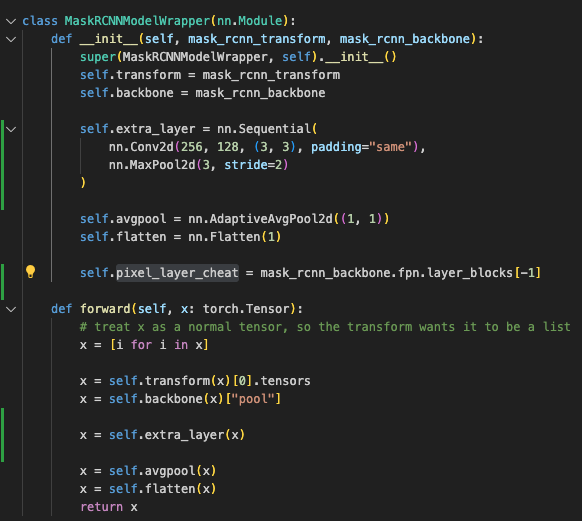